In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from datetime import datetime

# Load Data

In [2]:
data = pd.concat((
    pd.read_csv('data/5YearData.csv'),
    pd.read_csv('data/1YearData.csv'),
)).set_index('Date')
data.index = pd.to_datetime(data.index, format='%d/%m/%Y')

news = pd.concat((
    pd.read_csv('data/News1year.csv', encoding='latin1', header=None, names=['Date','Title','Evaluation', 'Prob'], index_col=0),
    pd.read_csv('data/News5years.csv', encoding='latin1', header=None, names=['Date','Title','Evaluation', 'Prob'], index_col=0),
)).sort_index()
news.index = pd.to_datetime(news.index.map(lambda x: x[:10]))

news['Evaluation'] = news['Evaluation'].map({'negative': 0, 'neutral': 0.5, 'positive': 1})
news_evaluation = pd.Series({date: d['Evaluation'].dot(d['Prob']) / d['Prob'].sum() for date, d in news.groupby('Date')}).rename('News')

dataset = pd.merge(data, news_evaluation.to_frame(), left_index=True, right_index=True).dropna()
dataset.head()

,Open,High,Low,Close,Adj Close,Volume,Amazon,Microsoft,Google,NASDAQ,NYSE,RUSSELL2000,ViX,USD/CNY,5yearTreasury,10yearTreasury,News
2017-07-31,37.474998,37.582500,37.032501,37.182499,34.990471,79383600,49.389000,67.442795,46.525002,6348.120117,11967.66992,1425.140015,10.26,6.7389,1.832,2.292,0.000000
2017-08-01,37.275002,37.555000,37.102501,37.512501,35.301014,141474400,49.809502,67.331490,46.541500,6362.939941,12000.01953,1428.329956,10.09,6.7255,1.799,2.251,0.639692
2017-08-02,39.820000,39.937500,39.040001,39.285000,36.969032,279747200,49.794498,67.034630,46.519501,6362.649902,11979.37012,1412.900024,10.28,6.7137,1.819,2.262,0.629514
2017-08-03,39.262501,39.302502,38.755001,38.892502,36.599667,108389200,49.346001,66.932602,46.182499,6340.339844,11956.51953,1405.229980,10.44,6.7217,1.790,2.228,0.652183
2017-08-04,39.017502,39.349998,38.922501,39.097500,36.792587,82239600,49.379002,67.424248,46.397999,6351.560059,11984.88965,1412.319946,10.03,6.7156,1.822,2.267,0.500000


# Add Technical Indicators

In [3]:
def get_technical_indicators(dataset, key='Close'):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset[key].rolling(window=7).mean()
    dataset['ma21'] = dataset[key].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset[key].ewm(span=26).mean()
    dataset['12ema'] = dataset[key].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset[key].rolling(window=20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset[key].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset[key]-1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    
    return dataset
    

dataset = get_technical_indicators(dataset).dropna()

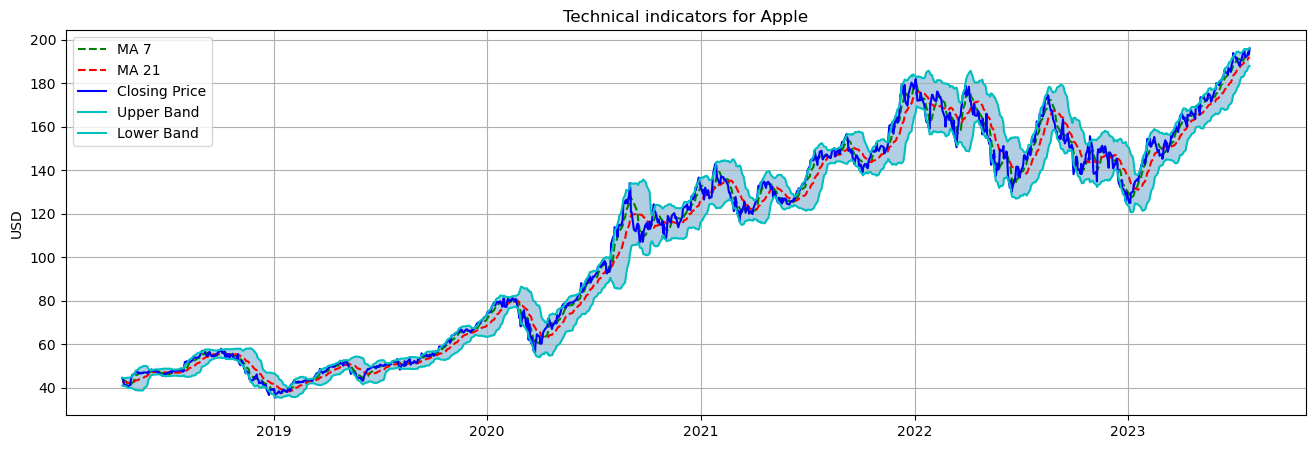

In [9]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 5), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title(f'Technical indicators for Apple')
    plt.ylabel('USD')
    plt.grid()
    plt.legend()
    plt.show()

plot_technical_indicators(dataset, 1200)

# Fourier transforms

## IFFT

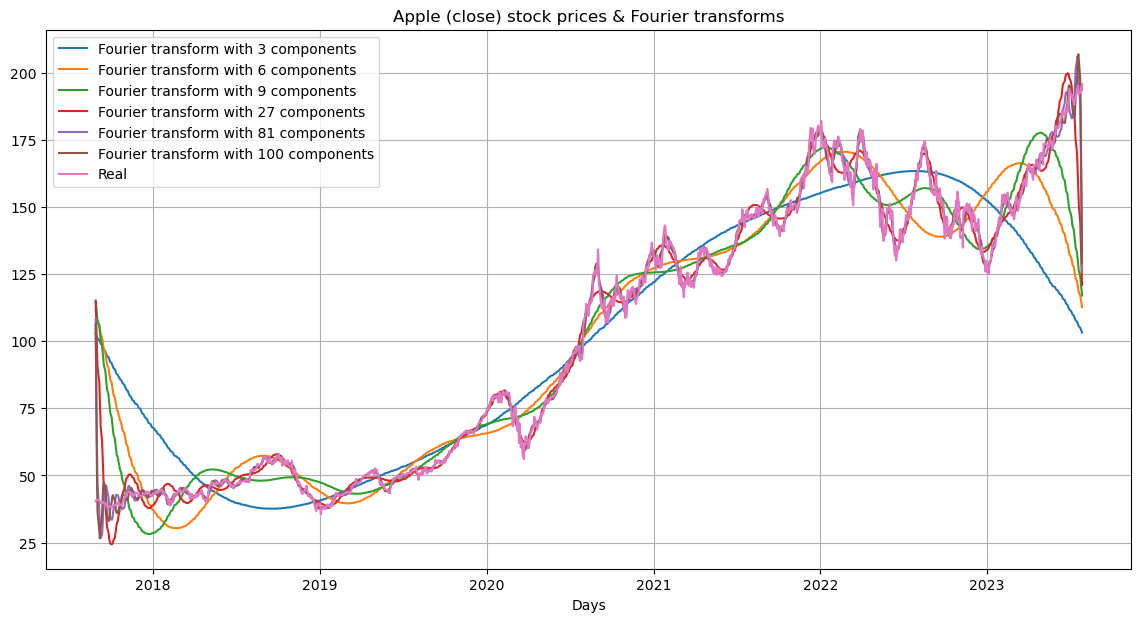

In [49]:
y = dataset['Close'].to_numpy()
y_fft = np.fft.fft(y)

plt.figure(figsize=(14, 7), dpi=100)
for n in [3, 6, 9, 27, 81, 100]:
    y_fft_ = y_fft.copy()
    y_fft_[n: -n] = 0
    dataset[f'FT_{n}components'] = np.real(np.fft.ifft(y_fft_))
    plt.plot(dataset[f'FT_{n}components'], label=f'Fourier transform with {n} components')
    
plt.plot(dataset['Close'],  label='Real')
plt.xlabel('Days')
plt.title('Apple (close) stock prices & Fourier transforms')
plt.legend()
plt.grid()
plt.show()

## SFFT

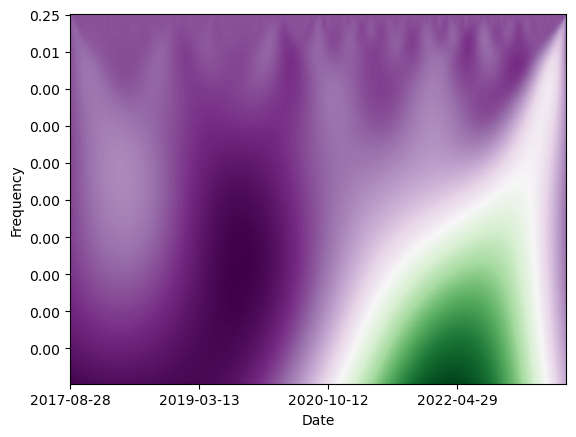

In [212]:
import pywt

y = dataset['Close'].to_numpy()

# get sfft
widths = np.arange(1, 300)
cwtmatr, freqs = pywt.cwt(y, widths, 'mexh')
for i in range(0, len(cwtmatr), 30):
    # cwtmatr[i] = np.abs(cwtmatr[i])
    dataset[f'sfft{i}'] = cwtmatr[i]

plt.imshow(cwtmatr, cmap='PRGn', aspect='auto')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, len(dataset), 350), list(map(lambda dt: dt.date(), dataset.index))[::350])
plt.yticks(np.arange(0, len(freqs), 30), list(map(lambda f: f'{f:.2f}',freqs[::30])))
plt.show()

In [211]:
dataset.shape

(1347, 51)

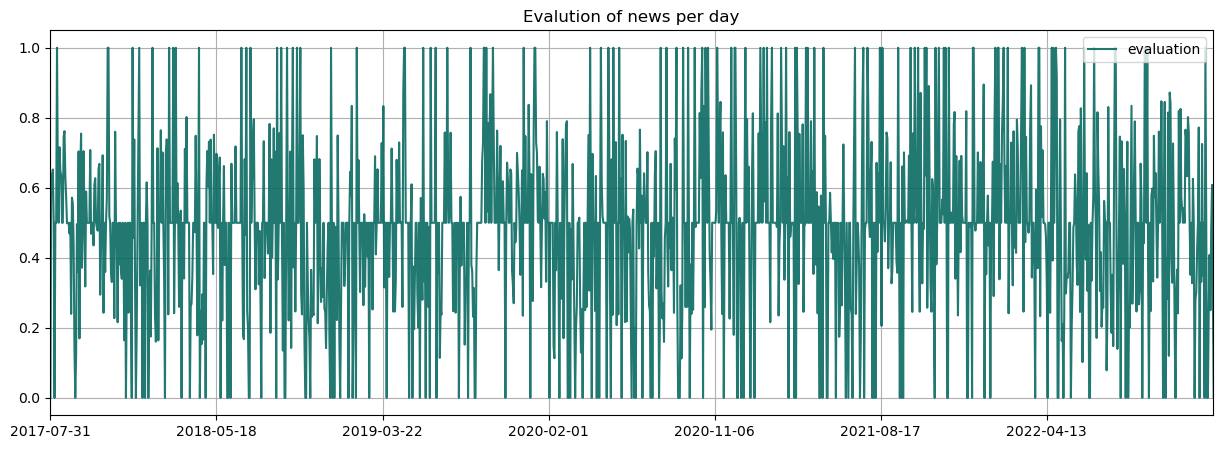

In [153]:
pd.Series({date: d['evaluation'].dot(d['prob']) / d['prob'].sum() for date, d in news.groupby('date')}).to_frame('evaluation').plot(
    figsize=(15, 5), 
    title='Evalution of news per day', 
    grid=True, 
    color='#096A62', 
    alpha=0.9,
    xticks=range(0, 1400, 200),
    xlim=(0, 1400)
)
plt.savefig('images/evalution_per_day.png', bbox_inches='tight', dpi=300)

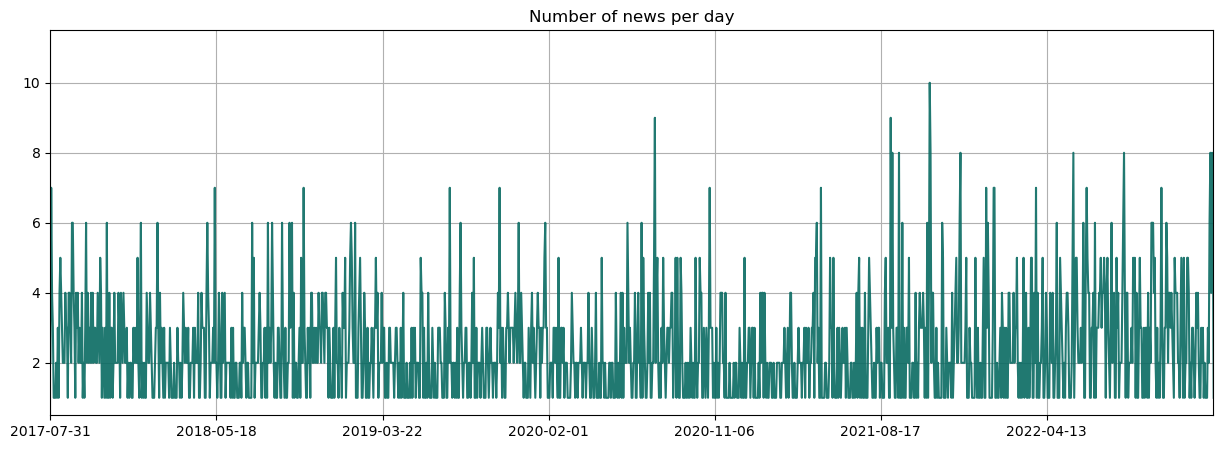

In [129]:
news['date'].value_counts().sort_index().plot(
    figsize=(15, 5), 
    title='Number of news per day', 
    grid=True, 
    color='#096A62', 
    alpha=0.9,
    xticks=range(0, 1400, 200),
    xlim=(0, 1400)
)
plt.savefig('images/news_per_day.png', bbox_inches='tight', dpi=300)

In [130]:
news['date']


0       2017-07-31
1       2017-07-31
2       2017-08-01
3       2017-08-01
4       2017-08-01
           ...    
3880    2023-07-27
3881    2023-07-28
3882    2023-07-28
3883    2023-07-28
3884    2023-08-01
Name: date, Length: 3885, dtype: object

0.5005829162607187